Run inference. (Without quantitative evaluation, no annotations required.)

In [ ]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

%load_ext autoreload
%autoreload 2

from dotenv import load_dotenv
load_dotenv()

from google.cloud import storage
from project_config import GCP_PROJECT_NAME

gcp_client = storage.Client(project=GCP_PROJECT_NAME)

## Configuration
Chose model configuration, path to trained weights and location to run inference on.

For information on inference strategy, read https://www.notion.so/andoshah/Inference-strategy-4da86e75cad848eeada298141ef23370?pvs=4

In [2]:
from experiment_configs.unet_fs_config import unet_orig_config
config = unet_orig_config
config.batch_size = 8

#from project_config import N_EDGE_PIXELS_DISCARD

from os.path import expanduser
path_to_weights = expanduser("~/sandmining-watch/out/1031-unet-orig-160/last-model.pth")

LOCATION = "Kathajodi_Cuttack_85-85_20-44"

In [3]:
## Additional filtering of observations
filter_fcn = lambda x: x.name.endswith('2022-02-01')

## For no additional filterting, comment out the following line:
#filter_fcn  = lambda _: True

In [ ]:
from utils.data_management import all_observations_for_location

observations_in_locations = list(all_observations_for_location(gcp_client, "Kathajodi_Cuttack_85-85_20-44"))
observations_for_inference = list(filter(filter_fcn,  observations_in_locations))

print(f"Aggregated {len(observations_for_inference)} observations for inference")

In [ ]:

from utils.rastervision_pipeline import observation_to_scene, scene_to_inference_ds

datasets_for_inference = []

for observation in observations_for_inference:
    scene = observation_to_scene(config, observation)
    dataset = scene_to_inference_ds(config, scene, full_image=False)
    datasets_for_inference.append(dataset)

In [6]:
from ml.learner import BinarySegmentationPredictor
from models.model_factory import model_factory


_, _, n_channels = dataset.scene.raster_source.shape
model = model_factory(
    config,
    n_channels=n_channels,
)

predictor = BinarySegmentationPredictor(
    config, model, path_to_weights
)


In [8]:
for dataset in datasets_for_inference:
    scores, preds = predictor.predict_mine_probability_for_site(dataset, N_EDGE_PIXELS_DISCARD)


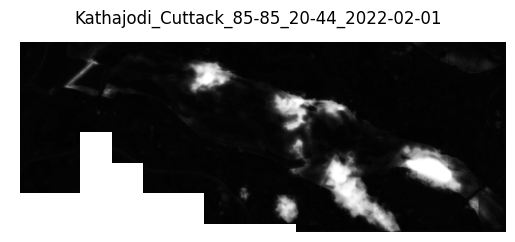

In [7]:
import matplotlib.pyplot as plt

for dataset in datasets_for_inference:
    predicted_probs_img = predictor.predict_mine_probability_for_site(dataset)
    plt.imshow(predicted_probs_img, vmin=0, vmax=1, cmap='gray')
    plt.axis('off')
    plt.title(dataset.scene.id)
    plt.show()